# Content based Filtering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collaborative_filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
women_wear_2018_winter_some_df = pd.read_csv("./women_wear_2018_winter.csv")

In [3]:
%%time

avg_percision = []
mean_avg_percision = []
num_users = []
timeline = []

# week 44 - 52
for wk in range(44,52):
    masking = women_wear_2018_winter_some_df.week == wk #subset only one week of training data
    df_x_train = women_wear_2018_winter_some_df.loc[masking].reset_index(drop=True)
    masking = women_wear_2018_winter_some_df.week == wk+1
    df_x_test = women_wear_2018_winter_some_df.loc[masking].reset_index(drop=True)[['customer_id','article_id']]

    #concatenate all text information
    df_x_train['details_description'] = df_x_train['product_type_name'] + " " + \
                                     df_x_train['product_group_name'] + " " + \
                                     df_x_train['graphical_appearance_name'] + " " + \
                                     df_x_train['colour_group_name'] + " " + \
                                     df_x_train['perceived_colour_value_name'] + " " + \
                                     df_x_train['perceived_colour_master_name'] + " " + \
                                     df_x_train['department_name'] + " " + \
                                     df_x_train['section_name'] + " " + \
                                     df_x_train['garment_group_name'] + " " + \
                                     df_x_train['detail_desc']

    #subset article_id and description column
    df_article_description = df_x_train[['article_id','details_description']].drop_duplicates().dropna().reset_index(drop=True)

    #TF-IDF
    tf_idf_vectorizer = TfidfVectorizer()
    df_vector = tf_idf_vectorizer.fit_transform(df_article_description['details_description'])

    #Calculate cosine similarity between articles
    cos_sim = cosine_similarity(df_vector)

    #sort index of similarity
    sorted_cos_sim = np.fliplr(np.argsort(cos_sim))

    #find customers in training and their purchases items
    cIds = df_x_train.customer_id.unique()

    #dict to save customer_id and recommended article_ids
    recommended_items = {}

    for cId in cIds:

        #find items purchased by customer in training
        purchased = list(df_x_train.loc[df_x_train.customer_id == cId].article_id.unique())

        #empty list to store similarity array for each purchased item
        items_similar = []

        #for each article_id, find its 5 most similar items' similarites
        for p in purchased:

            #article_id's index
            article_index = np.where(df_article_description.article_id == p)[0]

            if article_index.size == 1:
                article_index = article_index[0]
                #use article_id's index to get its similarity vectors with others and append to list
                items_similar.append(cos_sim[article_index])

        #if no similarity item, go to next customer
        if len(items_similar) == 0:
            break
        
        #convert similarity_items list to np array
        items_similar = np.asarray(items_similar)

        #replace 1. with 0 in the similarity_items (1 is the item itself)
        items_similar[items_similar > 0.999] = 0

        #Get index of 5 highest similarity for each purchased item
        high_sim_index = np.argpartition(items_similar, -5)[:,-5:].flatten()

        #Get similarity using above index info
        high_similarity = np.take(items_similar, high_sim_index).flatten()

        #make a dataframe
        item_index_sim_df = pd.DataFrame({"item_idx":high_sim_index, "similarity":high_similarity})
        #sort by similarity and get the first 5 items
        item_index_sim_df = item_index_sim_df.sort_values('similarity', ascending=False).reset_index(drop=True)[0:5]

        #retrieve the article_id by index
        recommend_article_ids = list(df_article_description.article_id[list(item_index_sim_df.item_idx)])

        #add user_id and recommended items to dict
        recommended_items[cId] = recommend_article_ids

       
    # calculating average percision for top 10 recommended items
    avg_perp, num_user = collaborative_filtering.average_of_precision(recommended_items, df_x_test)
    avg_percision.append(avg_perp)

    # calculating mean_avg_percision for top 10 recommended items
    mean_avg_per, num_user = collaborative_filtering.mean_average_precision(recommended_items, df_x_test)
    mean_avg_percision.append(mean_avg_per)

    #append number of users
    num_users.append(num_user)
    
    #append week to timeline
    timeline.append('Wk_'+str(wk+1))


 17%|█▋        | 596/3508 [00:00<00:00, 5947.82it/s]

Number of users: 89


 16%|█▌        | 566/3612 [00:00<00:00, 5658.21it/s]

Number of users: 124


 12%|█▏        | 426/3665 [00:00<00:00, 4199.84it/s]

Number of users: 66


 18%|█▊        | 619/3506 [00:00<00:00, 6140.16it/s]

Number of users: 63


 13%|█▎        | 480/3601 [00:00<00:00, 4769.51it/s]

Number of users: 113


 17%|█▋        | 608/3652 [00:00<00:00, 6049.92it/s]

Number of users: 119


 15%|█▌        | 544/3570 [00:00<00:00, 5417.18it/s]

Number of users: 86


 17%|█▋        | 627/3732 [00:00<00:00, 6261.05it/s]

Number of users: 97


100%|██████████| 3732/3732 [00:00<00:00, 5115.54it/s]

Wall time: 2min


In [4]:
mean_avg_percision

[0.04711610486891387,
 0.06940860215053765,
 0.06378787878787877,
 0.03788359788359789,
 0.06749262536873156,
 0.06439775910364146,
 0.029457364341085274,
 0.05508591065292097]

In [5]:
#save results in a dataframe
result_df = pd.DataFrame({'timeline':timeline,
                          'avg_percision':avg_percision,
                          'mean_avg_percision':mean_avg_percision,
                          'num_users':num_users})

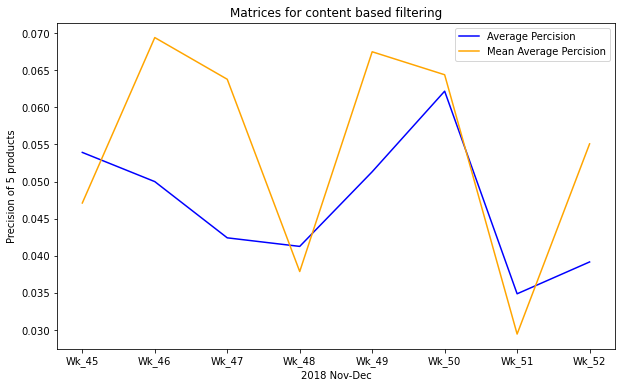

In [6]:
#plot for AOP MAP
plt.figure(figsize=(10,6))
plt.plot(result_df.timeline, result_df.avg_percision, color= 'blue')
plt.plot(result_df.timeline, result_df.mean_avg_percision, color= 'orange')
plt.title("Matrices for content based filtering")

plt.xlabel('2018 Nov-Dec')
plt.ylabel('Precision of 5 products')
plt.legend(['Average Percision','Mean Average Percision'])

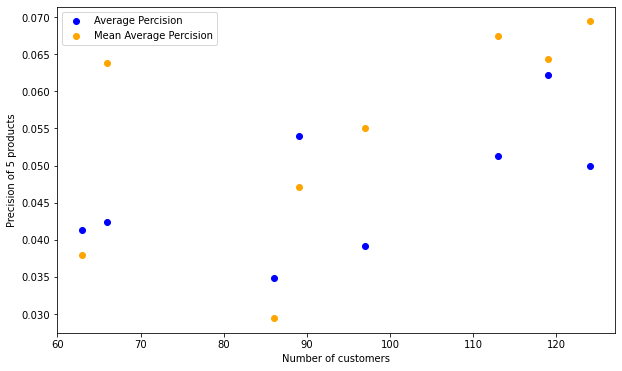

In [7]:
#scatter plot for avg_percision and mean_avg_percision against number of users
plt.figure(figsize=(10,6))
plt.scatter(result_df.num_users, result_df.avg_percision, color = 'blue')
plt.scatter(result_df.num_users, result_df.mean_avg_percision, color = 'orange')
plt.xlabel('Number of customers')
plt.ylabel('Precision of 5 products')
plt.legend(['Average Percision','Mean Average Percision'])